In [1]:
# visualize model outputs on val dataset

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from munch import Munch

import datasets
import models
import utils

In [43]:
coke_data_root = '../data/CokeDataset'
ann_file = '20190517_Coke.json'
camera_name = 'kinect1'
#mode = 'object'
mode = 'mask'
config_path = 'pretrained/kinect1_{}/config.yml'.format(mode)
blender_path = '/usr/local/bin/blender'

In [44]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [45]:
camera_parameters = utils.get_camera_parameters(coke_data_root, ann_file, camera_name)
model_paths = utils.get_model_paths(coke_data_root, ann_file, cfg.data.objects)
pose_renderers = [
    utils.PoseRenderer(blender_path, camera_parameters, model_path, mode)
    for model_path in model_paths
]

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [46]:
model = models.Model(cfg.arch)
model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True
checkpoint = torch.load(cfg.training.resume)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("=> loaded checkpoint '{}' (epoch {})".format(cfg.training.resume, checkpoint['epoch']))

=> loaded checkpoint 'pretrained/kinect1_mask/checkpoint_00002100.pth.tar' (epoch 2100)


In [47]:
transform = transforms.ToTensor()
val_dataset = datasets.RenderedPoseDataset(
    cfg.data.root, cfg.data.objects, cfg.data.val_subset_num, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

In [48]:
def visualize_batch(model, pose_renderers, input, target, object_index):
    target = target.cuda(non_blocking=True)
    object_index = object_index.cuda(non_blocking=True)
    position, orientation = model(input, object_index)
    position_error = (target[:, :3] - position).pow(2).sum(dim=1).sqrt()
    orientation_error = 180.0 / np.pi * utils.batch_rotation_angle(target[:, 3:], orientation)

    image = input.numpy()
    image = image.squeeze(1) if image.shape[1] == 1 else image.transpose((0, 2, 3, 1))
    object_index = object_index.cpu().numpy()
    position = position.cpu().numpy()
    orientation = orientation.cpu().numpy()

    for i in range(input.size(0)):
        _, axes = plt.subplots(1, 2, figsize=(2 * 4, 4))
        rendered_pose = pose_renderers[object_index[i]].render(position[i], orientation[i])
        axes[0].imshow(image[i], cmap='gray' if image.ndim == 3 else None)
        axes[1].imshow(rendered_pose, cmap='gray' if image.ndim == 3 else None)
        plt.show()
        print('position error: {:.4f} meters'.format(position_error[i]))
        print('orientation error: {:.2f} degrees'.format(orientation_error[i]))
        print('\n')

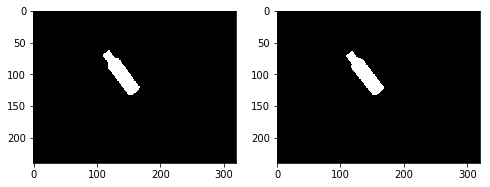

position error: 0.0022 meters
orientation error: 140.54 degrees




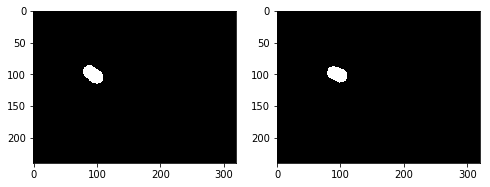

position error: 0.0059 meters
orientation error: 101.46 degrees




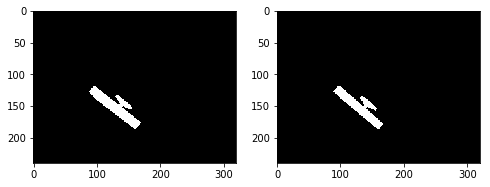

position error: 0.0082 meters
orientation error: 7.52 degrees




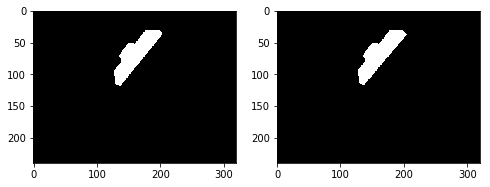

position error: 0.0081 meters
orientation error: 4.34 degrees




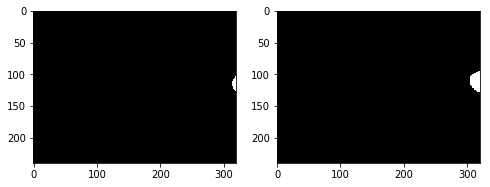

position error: 0.0884 meters
orientation error: 122.26 degrees




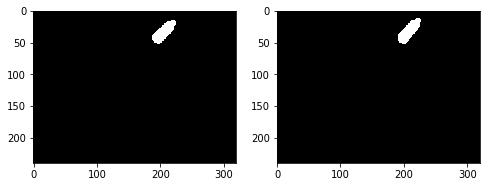

position error: 0.0090 meters
orientation error: 94.24 degrees




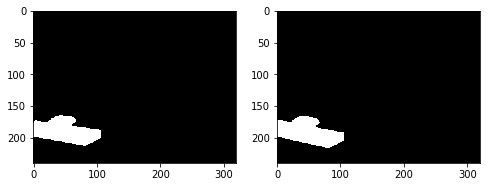

position error: 0.0062 meters
orientation error: 6.57 degrees




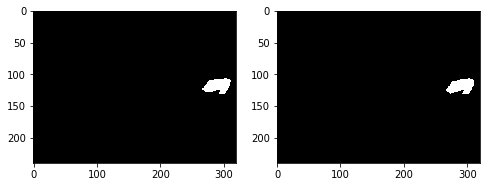

position error: 0.0064 meters
orientation error: 1.22 degrees




In [49]:
# display random pairs of (input image, rendered pose estimate)
count = 0
num_examples = 8

with torch.no_grad():
    for input, target, object_index in val_loader:
        visualize_batch(model, pose_renderers, input, target, object_index)
        count += input.size(0)
        if count == num_examples:
            break